<a href="https://colab.research.google.com/github/umairiqbal78/Deep-learning-Projects/blob/main/Toxic_comment_classification_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score # auc means area under curve metric is given to us which is helpful for classification problem

In [ ]:

from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100 #size of each word vector
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


In [ ]:

# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/MyDrive/Glove_embedding/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [ ]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("/content/drive/MyDrive/toxic_comments_udemy/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
len(targets)


Loading in comments...


159571

In [ ]:

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()

In [ ]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))


max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

# exit()

Found 210337 unique tokens.


In [ ]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE: 
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [ ]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer= Adam(lr=0.01),
  metrics=['accuracy'],
)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...


In [ ]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 53s 53ms/step - loss: 0.0820 - accuracy: 0.9742 - val_loss: 0.0613 - val_accuracy: 0.9939
Epoch 2/10
998/998 [==============================] - 59s 59ms/step - loss: 0.0565 - accuracy: 0.9939 - val_loss: 0.0563 - val_accuracy: 0.9937
Epoch 3/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0541 - accuracy: 0.9928 - val_loss: 0.0564 - val_accuracy: 0.9900
Epoch 4/10
998/998 [==============================] - 54s 54ms/step - loss: 0.0527 - accuracy: 0.9916 - val_loss: 0.0550 - val_accuracy: 0.9935
Epoch 5/10
998/998 [==============================] - 55s 56ms/step - loss: 0.0518 - accuracy: 0.9919 - val_loss: 0.0546 - val_accuracy: 0.9881
Epoch 6/10
998/998 [==============================] - 55s 56ms/step - loss: 0.0513 - accuracy: 0.9920 - val_loss: 0.0548 - val_accuracy: 0.9929
Epoch 7/10
998/998 [==============================] - 56s 56ms/step - loss: 0.0506 - accuracy: 0.9909 - val_loss: 0.05

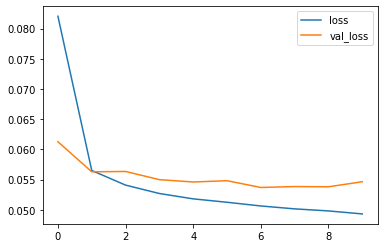

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

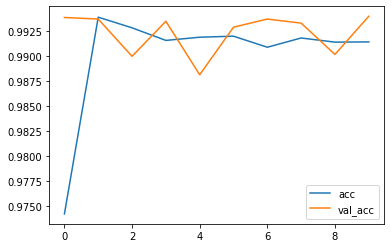

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# plot the mean AUC over each label
p = model.predict(data)
print(p)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

[[1.5276968e-03 5.4964890e-05 1.8104911e-04 6.3875785e-05 2.6875734e-04
  1.4671683e-04]
 [1.2642741e-03 6.1570907e-05 1.7663836e-04 6.7041357e-05 2.4443865e-04
  1.1085142e-04]
 [1.5791655e-02 3.0371547e-04 7.6547265e-04 7.6937675e-04 2.3422837e-03
  1.5047491e-03]
 ...
 [5.2151680e-02 8.7827444e-04 1.2039781e-02 2.1213293e-04 4.5429468e-03
  4.3675303e-04]
 [2.5506705e-02 6.9767237e-04 3.3799112e-03 8.7356567e-04 3.3744872e-03
  6.4536929e-04]
 [5.6576967e-02 6.7037344e-04 7.8153610e-03 4.3410063e-04 7.2504878e-03
  1.0481775e-03]]
0.9747441132260953


In [ ]:
import pickle

modelStoragePath = "/content/drive/MyDrive/toxic_comments_udemy"

def saveData(model, r , iteration):
    modelFile = modelStoragePath + "model_LSTM_toxic_comments_model" + str(iteration).strip() + ".h5"
    rFile = modelStoragePath + "_History_LSTM_toxic_comments_model" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving r  file too
    with open(rFile, 'wb') as file_pi:
        pickle.dump(r.history, file_pi)
    return modelFile, rFile

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "model_LSTM_toxic_comments_model" + str(iteration).strip() + ".h5"
    rFile = modelStoragePath + "_History_LSTM_toxic_comments_model" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(rFile, 'rb') as file_pi:
        r  = pickle.load(file_pi)
    return model,  r

In [ ]:
print(type(r))
modelFile, rFile = saveData(model, r, iteration=1)
print(modelFile, rFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/MyDrive/toxic_comments_udemymodel_LSTM_toxic_comments_model1.h5 /content/drive/MyDrive/toxic_comments_udemy_History_LSTM_toxic_comments_model1.pkle Saved


In [ ]:
print('Building model...')


input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer= Adam(lr=0.01),
  metrics=['accuracy'],
)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d (Global (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 186       
Total params: 2,014,106
Trainable params: 14,106
Non-trainable params: 2,000,000
_________________________________________________________________


In [ ]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0715 - accuracy: 0.9649 - val_loss: 0.0573 - val_accuracy: 0.9926
Epoch 2/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0538 - accuracy: 0.9766 - val_loss: 0.0552 - val_accuracy: 0.9911
Epoch 3/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0503 - accuracy: 0.9720 - val_loss: 0.0525 - val_accuracy: 0.8053
Epoch 4/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0485 - accuracy: 0.9601 - val_loss: 0.0522 - val_accuracy: 0.9845
Epoch 5/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0473 - accuracy: 0.9580 - val_loss: 0.0521 - val_accuracy: 0.9346
Epoch 6/10
998/998 [==============================] - 92s 93ms/step - loss: 0.0465 - accuracy: 0.9472 - val_loss: 0.0522 - val_accuracy: 0.9885
Epoch 7/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0455 - accuracy: 0.9228 - val_loss: 0.05

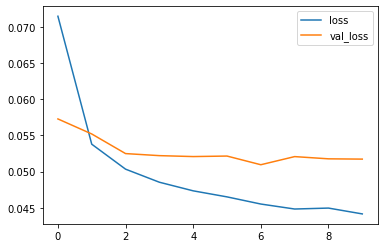

In [ ]:
import matplotlib.pyplot as plt

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

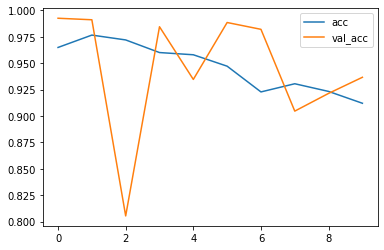

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# plot the mean AUC over each label
p = model.predict(data)
print(p)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

[[3.75589728e-03 7.42109914e-05 2.40880251e-03 1.42395496e-04
  1.88046694e-03 7.72021085e-05]
 [3.49819660e-04 5.93040249e-06 1.10658446e-04 1.74510376e-06
  1.35898590e-04 6.60499882e-06]
 [7.00950623e-04 5.97132612e-06 1.52379274e-04 1.01323599e-06
  1.15054179e-04 5.71003147e-06]
 ...
 [2.82128513e-01 7.51495361e-04 5.91973662e-02 3.15653051e-05
  1.93812549e-02 1.12870336e-03]
 [1.82482600e-03 1.50605374e-05 4.29481268e-04 4.85403780e-06
  3.47644091e-04 2.29654543e-05]
 [1.91991031e-02 1.68025494e-04 2.40355730e-03 4.74807675e-05
  2.41878629e-03 1.35689974e-04]]
0.985002049468679


In [ ]:
import pickle

modelStoragePath = "/content/drive/MyDrive/toxic_comments_udemy/"

def saveData(model, r , iteration):
    modelFile = modelStoragePath + "model_Bidirectional_LSTM_toxic_comments_model" + str(iteration).strip() + ".h5"
    rFile = modelStoragePath + "_History_Bidirectional_LSTM_toxic_comments_model" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving r  file too
    with open(rFile, 'wb') as file_pi:
        pickle.dump(r.history, file_pi)
    return modelFile, rFile

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "model_Bidirectional_LSTM_toxic_comments_model" + str(iteration).strip() + ".h5"
    rFile = modelStoragePath + "_History_Bidirectional_LSTM_toxic_comments_model" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(rFile, 'rb') as file_pi:
        r  = pickle.load(file_pi)
    return model,  r

In [ ]:
print(type(r))
modelFile, rFile = saveData(model, r, iteration=1)
print(modelFile, rFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/MyDrive/toxic_comments_udemymodel_Bidirectional_LSTM_toxic_comments_model1.h5 /content/drive/MyDrive/toxic_comments_udemy_History_Bidirectional_LSTM_toxic_comments_model1.pkle Saved
